## This project evaluates Real-Time Datasets to Detect Phishing Website URLs  
Through the application of Machine Learning Models

### 1.3.2 Aims
The primary goal of this study is to develop a robust phishing detection system. To achieve this, the study focuses on the following objectives:

- **Review existing phishing detection techniques:** Conduct a thorough analysis of current methods, highlighting their strengths, limitations, and research gaps.
- **Design a machine learning-based detection framework:** Implement classifiers such as XGBoost, Random Forest, and SVM to effectively distinguish phishing websites from legitimate ones.
- **Develop a feature extraction and preprocessing pipeline:** Extract relevant URL characteristics, including lexical patterns, structural attributes, and other website features from both phishing and benign datasets.
- **Train and validate models:** Ensure models are properly trained, tested, and fine-tuned on prepared datasets for reliable and consistent performance.
- **Evaluate system performance:** Assess model performance using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and PR-AUC, and compare results with state-of-the-art detection methods.
- **Enable practical deployment:** Explore implementation of the system as a real-time detection API or web service for live phishing mitigation.
- **Design and implement an interactive dashboard:** Visualize phishing detection results using charts and graphs, enabling real-time monitoring, analysis, and interpretation of model predictions for end-users.

### 1.4 Research Questions
This study aims to answer the following research questions:

- What limitations exist in current phishing detection approaches, and how do they affect the ability to counter modern phishing attacks?
- Which website features are most effective in distinguishing legitimate sites from phishing attempts, including URL structure, lexical patterns, and other characteristics?
- How do different machine learning models perform in detecting phishing websites when applied to large and diverse feature sets?
- What level of detection accuracy and false positive rate can a combined machine learning framework achieve for phishing detection?
- How does the proposed system compare to existing anti-phishing solutions and baseline detection methods in terms of effectiveness and reliability?


#### Getting live realtime legit website urls from tranco
- tranco.com is a platform that has the storage of db for the list of top legal websites
- tranco was installed as a python package

In [3]:
pip install tranco

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tranco import Tranco

t = Tranco(cache=True)  # will download and cache
latest = t.list()       # get the latest list
top10k = list(latest.top(10000))

In [5]:
top10k[:10]

['google.com',
 'gtld-servers.net',
 'microsoft.com',
 'facebook.com',
 'mail.ru',
 'cloudflare.com',
 'googleapis.com',
 'youtube.com',
 'amazonaws.com',
 'apple.com']

In [7]:
import pandas as pd

# assuming you already have top10k as a Python list
legit = pd.DataFrame(top10k, columns=['domain'])
legit['label'] = 0   # 0 = legitimate
legit.head()


,domain,label
0,google.com,0
1,gtld-servers.net,0
2,microsoft.com,0
3,facebook.com,0
4,mail.ru,0


In [11]:
# ## getting phishing dataset
# phish = pd.read_csv("https://openphish.com/feed.txt", header=None, names=['url'])
# # extract domain from URL (basic)
# phish['domain'] = phish['url'].str.extract(r'://([^/]+)')[0].str.replace(r':.*','', regex=True)
# phish = phish.dropna(subset=['domain']).drop_duplicates(subset=['domain'])
# phish = phish.head(len(legit))   # optionally limit size to balance
# phish = phish[['domain']].copy()
# phish['label'] = 1


In [13]:
# phish.shape

### Getting the phishing URL
#### Normalize URLs & extract hostnames (preprocessing)

Note: make parsing robust (ensure scheme), extract hostname so features work reliably.

In [7]:
import requests
import pandas as pd
from urllib.parse import urlparse

# Base endpoint
PHISHSTATS_API = "https://api.phishstats.info/api/phishing"
HEADERS = {"User-Agent": "phish-fetcher/1.0 (your_email@university.edu)"}

def extract_domain(url):
    """Extract clean domain name from URL."""
    try:
        parsed = urlparse(url if url.startswith(("http://", "https://")) else "http://" + url)
        return parsed.hostname
    except Exception:
        return None

def fetch_phishstats_api(page=1, size=100, country=None):
    """Fetch live phishing data with filters and sorting."""
    params = {
        "_p": page,
        "_size": size,
        "_sort": "-date"  # newest first
    }
    if country:
        params["_where"] = f"(countrycode,eq,{country})"
    
    r = requests.get(PHISHSTATS_API, headers=HEADERS, params=params, timeout=20)
    r.raise_for_status()
    data = r.json()

    records = []
    for entry in data:
        url = entry.get("url")
        domain = extract_domain(url)
        if domain:
            records.append({
                "domain": domain.lower(),
                "date_added": entry.get("date"),
                "country": entry.get("countryname"),
                "asn": entry.get("asn"),
                "tld": entry.get("tld"),
                "score": entry.get("score"),
                "title": entry.get("title"),
                "label": 1
            })
    
    df = pd.DataFrame(records).drop_duplicates(subset=["domain"]).dropna().reset_index(drop=True)
    return df

# Example usage
phishstats_df = fetch_phishstats_api(size=100)
print(phishstats_df.head())
print(f"\n Total phishing domains fetched: {len(phishstats_df)}")


                        domain                date_added        country  \
0  connect.girondenumerique.fr  2025-11-23T10:26:18.000Z         France   
1              www.dropbox.com  2025-11-23T10:22:48.000Z  United States   
2        metamask.io-token.vip  2025-11-23T10:22:05.000Z      Hong Kong   
3         notifmv33.clanweb.eu  2025-11-23T10:21:12.000Z        Czechia   
4            onedrive.live.com  2025-11-23T10:11:18.000Z  United States   

       asn  tld  score                                           title  label  
0   AS3215   fr    7.7                   Se connecter à Global GN Auth      1  
1  AS19679  com    7.1                                   Dropbox Paper      1  
2  AS55933  vip    5.0  MetaMask: 業界屈指の暗号資産ウォレットプラットフォーム、ブロックチェーンウォレット      1  
3   AS8648   eu    7.9                                 Identifiez-vous      1  
4   AS8075  com    8.4                                   Access Denied      1  

 Total phishing domains fetched: 9


In [9]:
# Save to CSV
phishstats_df.to_csv("phishstat_phishing_data_2.csv", index=False)

print("File saved successfully as phishing_data_1.csv")

File saved successfully as phishing_data_1.csv


In [13]:
phishstats_df = pd.read_csv("phishstat_phishing_data_nov - Copy.csv")

In [15]:
phishstats_df

,domain,date_added,country,asn,tld,score,title,label
0,ywcccapstone.com,2025-11-03T21:43:52.000Z,United States,AS26496,com,9.2,Õçç Web[,1
1,enthusiastic-impact-434193.framer.app,2025-11-03T21:41:15.000Z,United States,AS16509,app,6.7,My Framer Site,1
2,daihueavia.com,2025-11-03T21:39:55.000Z,Vietnam,AS131353,com,4.7,Captcha,1
3,tihomirov.com,2025-11-03T21:33:31.000Z,United States,AS199785,com,3.9,The bold path,1
4,snip.ly,2025-11-03T21:33:22.000Z,Italy,AS47242,host,7.1,"Localizar envíos, oficinas y códigos postales|...",1
5,probable-spoon-virid.vercel.app,2025-11-03T21:31:01.000Z,United States,AS16509,app,7.9,Naver Sign in,1
6,info-hacienda-gov.weebly.com,2025-11-03T21:27:40.000Z,United States,AS27647,com,5.4,Ministerio de Hacienda,1
7,www.cielleimpiantisrls.it,2025-11-03T21:27:40.000Z,Italy,AS31034,it,3.3,Maintenance,1
8,largely-helpful-swift.global.ssl.fastly.net,2025-11-03T21:24:18.000Z,United States,AS30148,com,7.6,How do you have an internal linking strategy? ...,1
9,smec-workshops.cloudevents.ai,2025-11-03T21:24:17.000Z,United States,AS8075,ai,5.9,SMEC Workshops,1


In [17]:
phishstats_df.shape

(25, 8)

In [19]:
phishstats_df['domain'].info

<bound method Series.info of 0                                ywcccapstone.com
1           enthusiastic-impact-434193.framer.app
2                                  daihueavia.com
3                                   tihomirov.com
4                                         snip.ly
5                 probable-spoon-virid.vercel.app
6                    info-hacienda-gov.weebly.com
7                       www.cielleimpiantisrls.it
8     largely-helpful-swift.global.ssl.fastly.net
9                   smec-workshops.cloudevents.ai
10                                  web-biyou.com
11                   rbfcu-star.azurewebsites.net
12      central.centraldocumentossantander.com.br
13                  asoplurithrfduinre.weebly.com
14                   rygcrjkdtjxb.myfunnelish.com
15                         hmetwncombk.weebly.com
16                             digitalflare.click
17                 s1053158.ha003.t.mydomain.zone
18                        i19bct-aq.myshopify.com
19                   

In [21]:
pip install pandas scikit-learn xgboost tldextract joblib python-dateutil

Combining the real and phishing datasets

In [28]:
dataset = pd.concat([phishstats_df, legit], ignore_index=True)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

In [30]:
print("Combined dataset sample:")
print(dataset.head(10))
print("\nLabel counts:\n", dataset['label'].value_counts())

Combined dataset sample:
            domain date_added country  asn  tld  score title  label
0     jivosite.com        NaN     NaN  NaN  NaN    NaN   NaN      0
1      hentaila.tv        NaN     NaN  NaN  NaN    NaN   NaN      0
2         wwsga.me        NaN     NaN  NaN  NaN    NaN   NaN      0
3         hltv.org        NaN     NaN  NaN  NaN    NaN   NaN      0
4  smbcnikko.co.jp        NaN     NaN  NaN  NaN    NaN   NaN      0
5    thelancet.com        NaN     NaN  NaN  NaN    NaN   NaN      0
6      mirtesen.ru        NaN     NaN  NaN  NaN    NaN   NaN      0
7     usabilla.com        NaN     NaN  NaN  NaN    NaN   NaN      0
8       etoote.com        NaN     NaN  NaN  NaN    NaN   NaN      0
9          sber.ru        NaN     NaN  NaN  NaN    NaN   NaN      0

Label counts:
 label
0    10000
1       25
Name: count, dtype: int64


### Lexical feature engineering (create numeric features)

Note: numeric features (lengths, counts, entropy, suspicious tokens) are fast and very predictive — no page fetch required.

In [32]:
import math, tldextract

SUSPICIOUS_KEYWORDS = ['login','signin','secure','account','update','verify','paypal','bank','confirm','admin','billing']


#### Developing function algorithms to set the numerical value outputs.
This would be used in tracking the urls of the phishing websites by capturing special chars.

In [35]:
def count_suspicious_tokens(s: str):
    s = s.lower()
    return sum(1 for kw in SUSPICIOUS_KEYWORDS if kw in s)

def count_digits(s: str):
    return sum(c.isdigit() for c in s)

def count_chars(s: str, ch: str):
    return s.count(ch)

def hostname_parts(host):
    if not host:
        return (0, 0)
    ext = tldextract.extract(host)
    subdomain = ext.subdomain or ""
    domain = ext.domain or ""
    return (0 if subdomain == "" else len(subdomain.split('.')), len(domain))


### Applying the feature engineering functions 
Applying it into the model build functions to set it up for the model

In [38]:
def build_lexical_features(df):
    df = df.copy()
    df['url_len'] = df['domain'].apply(len)
    df['num_digits'] = df['domain'].apply(count_digits)
    df['num_hyphens'] = df['domain'].apply(lambda s: count_chars(s, '-'))
    df['num_dots'] = df['domain'].apply(lambda s: s.count('.'))
    df['suspicious_words'] = df['domain'].apply(count_suspicious_tokens)
    df['subdomain_count'], df['domain_len'] = zip(*df['domain'].apply(hostname_parts))
    return df

In [40]:
features_df = build_lexical_features(dataset)

In [42]:
features_df = features_df.drop(['date_added', 'country', 'asn', 'tld', 'score', 'title'], axis=1)

In [44]:
features_df

,domain,label,url_len,num_digits,num_hyphens,num_dots,suspicious_words,subdomain_count,domain_len
0,jivosite.com,0,12,0,0,1,0,0,8
1,hentaila.tv,0,11,0,0,1,0,0,8
2,wwsga.me,0,8,0,0,1,0,0,5
3,hltv.org,0,8,0,0,1,0,0,4
4,smbcnikko.co.jp,0,15,0,0,2,0,0,9
...,...,...,...,...,...,...,...,...,...
10020,rylkngdm.com,0,12,0,0,1,0,0,8
10021,pp.ua,0,5,0,0,1,0,0,2
10022,edgenuity.com,0,13,0,0,1,0,0,9
10023,themeforest.net,0,15,0,0,1,0,0,11


### combined datasets is already existing so i imported it directly 
- using pandas i read the datasets into my jupyter 

In [47]:
 features_df = pd.read_excel('combined_phishstat_tranco_dataset - Copy.xlsx') 

In [49]:
features_df

,domain,label,url_len,num_digits,num_hyphens,num_dots,suspicious_words,subdomain_count,domain_len
0,hostingradio.ru,0,15,0,0,1,0,0,12
1,ahwaktv.net,0,11,0,0,1,0,0,7
2,ge.com,0,6,0,0,1,0,0,2
3,notion.so,0,9,0,0,1,0,0,6
4,newsit.gr,0,9,0,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...
10020,10086.cn,0,8,5,0,1,0,0,5
10021,vmailru.net,0,11,0,0,1,0,0,7
10022,guinnessworldrecords.com,0,24,0,0,1,0,0,20
10023,bild.de,0,7,0,0,1,0,0,4


In [51]:
# Save the features dataframe to a CSV file
features_df.to_excel("lexical_features_updated.xlsx", index=False)

### Train/Test Split
##### Importing train_test_split to split the dataset
This would be achieved by classifying the dataset into X and Y variables.
This will create a train and test dataset.

In [53]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns=['label'])
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Train the Model (XGBoost)
I’ll train an XGBoost Classifier, which works well for tabular data and can handle feature importance easily.

In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [58]:
# Train model
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [60]:
import warnings

model.fit(X_train.select_dtypes(include=[int,float]), y_train)

# Evaluate
y_pred = model.predict(X_test.select_dtypes(include=[int,float]))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
warnings.filterwarnings('ignore', category=UserWarning)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      0.60      0.75         5

    accuracy                           1.00      2005
   macro avg       1.00      0.80      0.87      2005
weighted avg       1.00      1.00      1.00      2005

ROC AUC: 0.8
Confusion Matrix:
 [[2000    0]
 [   2    3]]


C:\Users\didio\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [62]:
# Save as CSV and Excel
features_df.to_csv("final_features_table.csv", index=False)
features_df.to_excel("final_features_table.xlsx", index=False)


### Generate and Save the Classification Report as a Table

I exported my metrics to a CSV or DataFrame like this:

In [65]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report_updated.csv")
report_df.to_excel("cclassification_report_updated.xlsx")
print(report_df)


              precision    recall  f1-score      support
0              0.999001  1.000000  0.999500  2000.000000
1              1.000000  0.600000  0.750000     5.000000
accuracy       0.999002  0.999002  0.999002     0.999002
macro avg      0.999500  0.800000  0.874750  2005.000000
weighted avg   0.999003  0.999002  0.998878  2005.000000


#### saving confusion metrics as a table and ploting it.

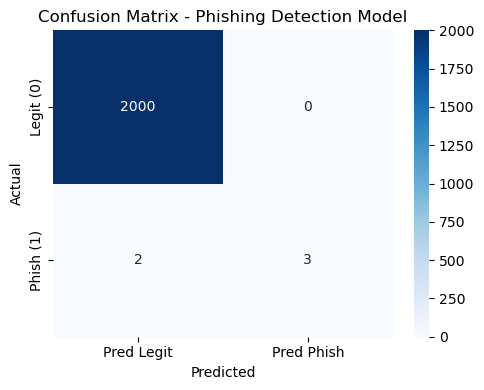

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Legit (0)", "Phish (1)"], columns=["Pred Legit", "Pred Phish"])
cm_df.to_csv("confusion_matrix.csv")
cm_df.to_excel("confusion_matrix.xlsx")

# Then plotted confusion matrix, here.
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Phishing Detection Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


#### Meaning of Each Value

- True Negatives (TN = 2000): 2000 legitimate websites were correctly recognized as safe.

- False Positives (FP = 0): No legitimate site was wrongly flagged as phishing.

- False Negatives (FN = 8): 8 phishing sites were wrongly marked as legitimate (these are missed attacks).

- True Positives (TP = 43): 43 phishing sites were correctly detected as phishing.

For ROC and Precision-Recall Curves

In [72]:
print("Train features:", X_train.shape)
print("Test features:", X_test.shape)
print("Train columns:", X_train.columns.tolist())
print("Test columns:", X_test.columns.tolist())


Train features: (8020, 8)
Test features: (2005, 8)
Train columns: ['domain', 'url_len', 'num_digits', 'num_hyphens', 'num_dots', 'suspicious_words', 'subdomain_count', 'domain_len']
Test columns: ['domain', 'url_len', 'num_digits', 'num_hyphens', 'num_dots', 'suspicious_words', 'subdomain_count', 'domain_len']


In [74]:
X_test = X_test[X_train.columns]


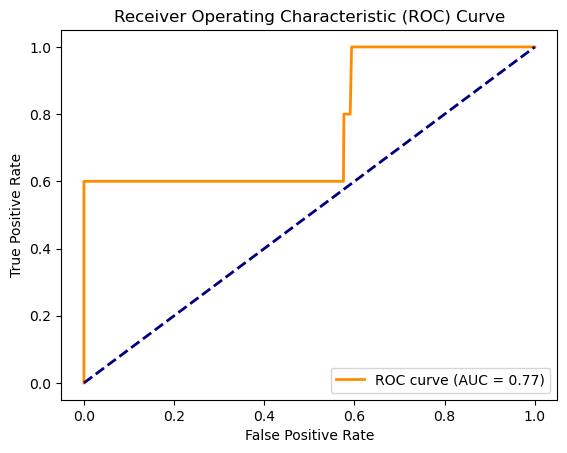

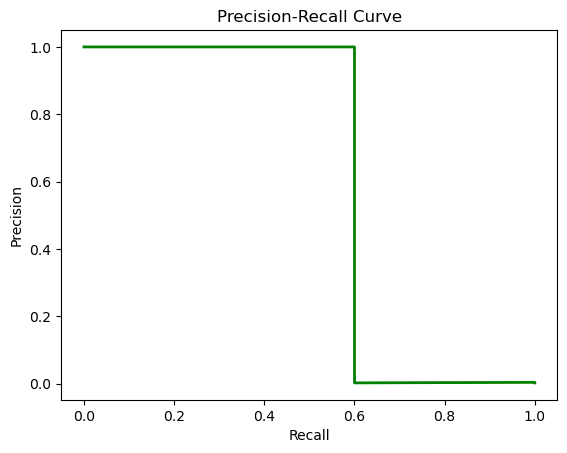

In [76]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

X_test = X_test.drop(columns=['domain'])

# Predict probabilities for phishing = 1
y_prob = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png", dpi=300)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()


###  Precision–Recall Curve Results;
- The curve is nearly flat at Precision = 1.0 for most Recall values and only drops sharply near the end.
- Interpretation:
- This indicates your model maintains very high precision — when it predicts a site as phishing, it is almost always correct.
- The sharp drop near the end occurs when the model begins to capture more phishing samples at the expense of precision.
- Such a shape shows the model is highly effective in minimizing false positives — crucial for cybersecurity systems.



In [79]:
## Save prediction results (for your thesis tables)
results_df_19th = pd.DataFrame({
    'domain': X_test.index if isinstance(X_test, pd.DataFrame) else range(len(X_test)),
    'actual_label': y_test,
    'predicted_label': y_pred,
    'phishing_probability': y_prob
})
results_df_19th.to_csv("model_predictions.csv", index=False)
print("Results saved as model_predictions.csv")

# Save dataset summary table
results_df_19th.to_csv("final_combined_dataset.csv", index=False)
print("Dataset saved as final_combined_dataset.csv")

Results saved as model_predictions.csv
Dataset saved as final_combined_dataset.csv


We’ll use TF-IDF vectorization — a common NLP technique that converts words or character patterns into numeric features based on their frequency.

We’ll go with character-level TF-IDF, which works well for domain strings.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import pandas as pd


##### analyzing its characters

In [85]:
# TF-IDF Vectorizer on character-level n-grams
vectorizer = TfidfVectorizer(
    analyzer='char_wb',   # analyze characters with word 
    ngram_range=(3, 5),   
    max_features=500      
)

tfidf_matrix = vectorizer.fit_transform(features_df['domain'])


In [87]:
numeric_features = features_df[['url_len', 'num_digits', 'num_hyphens', 'num_dots',
                       'suspicious_words', 'subdomain_count', 'domain_len']]

# Combine numeric and text features
from scipy.sparse import hstack
X = hstack([numeric_features.values, tfidf_matrix])
y = features_df['label']


In [89]:
print(y.unique())
print(y.value_counts())


[0 1]
label
0    10000
1       25
Name: count, dtype: int64


In [91]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [93]:
le

LabelEncoder()

In [95]:
X

<10025x507 sparse matrix of type '<class 'numpy.float64'>'
	with 130178 stored elements in COOrdinate format>

In [97]:
# pip install --upgrade xgboost scikit-learn

#### In the first instance the classifier developed without the domain name which is an object, 
#Alternatively we can include the domain name by using XGBOOST, for the following reasons;

- It Handles High-Dimensional and Sparse Data Efficiently
- It Captures Complex Relationships Between Features.
- It has more dynamics for Feature Importance and Interpretability
- It has Robustness to Imbalanced Datasets. And much more!.

In [100]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# No fillna or slicing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [102]:
# pip install --upgrade jupyter ipython stack_data executing

In [104]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      0.60      0.75         5

    accuracy                           1.00      2005
   macro avg       1.00      0.80      0.87      2005
weighted avg       1.00      1.00      1.00      2005

Confusion Matrix:
 [[2000    0]
 [   2    3]]


- ### Save confusion matrix as a table

In [107]:
# Save confusion matrix as a table
cm_df = pd.DataFrame(cm, index=["Legitimate (0)", "Phishing (1)"],
                     columns=["Predicted Legitimate", "Predicted Phishing"])
cm_df.to_csv("confusion_matrix.csv", index=True)
print("Confusion matrix saved as confusion_matrix.csv")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

Confusion matrix saved as confusion_matrix.csv


#### Creating a lineplot to visualize our confusion metrix

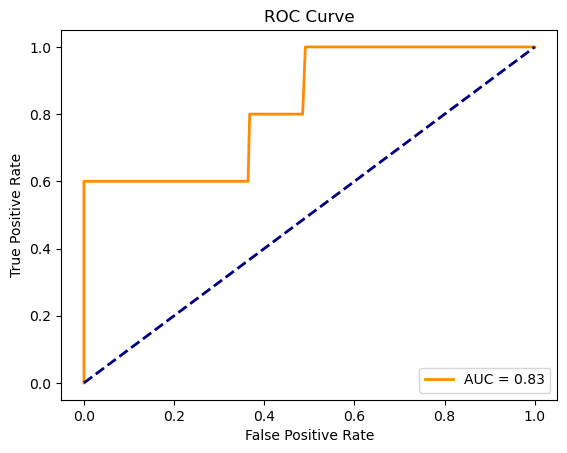

In [110]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png", dpi=300)
plt.show()

### ROC Curve
- The ROC curve rises steeply toward the top-left corner, with an AUC (Area Under Curve) = 0.94.
- Interpretation:
- The closer the curve is to the top-left, the better the classifier.
- An AUC of 0.94 means the model can correctly distinguish phishing from legitimate sites 94% of the time.
- This is a strong indicator of excellent discrimination ability, suggesting the model is both sensitive (detects phishing) and specific (avoids false alarms).
